<a href="https://colab.research.google.com/github/theoem/Data-Linkage/blob/master/Data_imputation/Data_imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Univairte, multivarite, mice

In [42]:
import missingno as msno ## specific python lib to analyse missingness
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

pd.set_option('max_columns', None)

regressor = RandomForestRegressor(random_state=0)

In [46]:
original = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv')

In [ ]:
files = [
         'houses_0.01_MAR.csv',
         'houses_0.01_MCAR.csv',
         'houses_0.01_MNAR.csv',
         'houses_0.1_MAR.csv',
         'houses_0.1_MCAR.csv',
         'houses_0.1_MNAR.csv',
         'houses_0.5_MAR.csv',
         'houses_0.5_MCAR.csv',
         'houses_0.5_MNAR.csv'
]
url = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/'

In [ ]:
dfs = []

for file in files:
  dfs.append(pd.read_csv(url + file))
print (len(dfs))

9


In [ ]:
for df in dfs:
  print(df.shape)
  print(df.columns)

(20640, 9)
Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',

In [ ]:
dfs[0]

,Unnamed: 0,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
...,...,...,...,...,...,...,...,...,...,...
20635,20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,-121.09
20636,20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,-121.21
20637,20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,-121.22
20638,20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,-121.32


Only keep the columns on which we apply regression

In [ ]:
index = 0
for df in dfs:
  dfs[index] = df.drop(['Unnamed: 0'], axis='columns')

Checking how many isnull values there are in each dataset

In [ ]:
index=0
for df in dfs:
  print(index)
  print(df.isnull().sum())
  index+=1

0
median_house_value        0
median_income         10320
housing_median_age    10320
total_rooms               0
total_bedrooms            0
population            10320
households                0
latitude                  0
longitude                 0
dtype: int64
1
Unnamed: 0              0
median_house_value      0
median_income         206
housing_median_age    206
total_rooms             0
total_bedrooms          0
population            206
households              0
latitude                0
longitude               0
dtype: int64
2
Unnamed: 0              0
median_house_value      0
median_income         206
housing_median_age    206
total_rooms             0
total_bedrooms          0
population            206
households              0
latitude                0
longitude               0
dtype: int64
3
Unnamed: 0               0
median_house_value       0
median_income         2064
housing_median_age    2064
total_rooms              0
total_bedrooms           0
population         

Only `median_income`, `housing_median_age` and `population` columns have missing values.

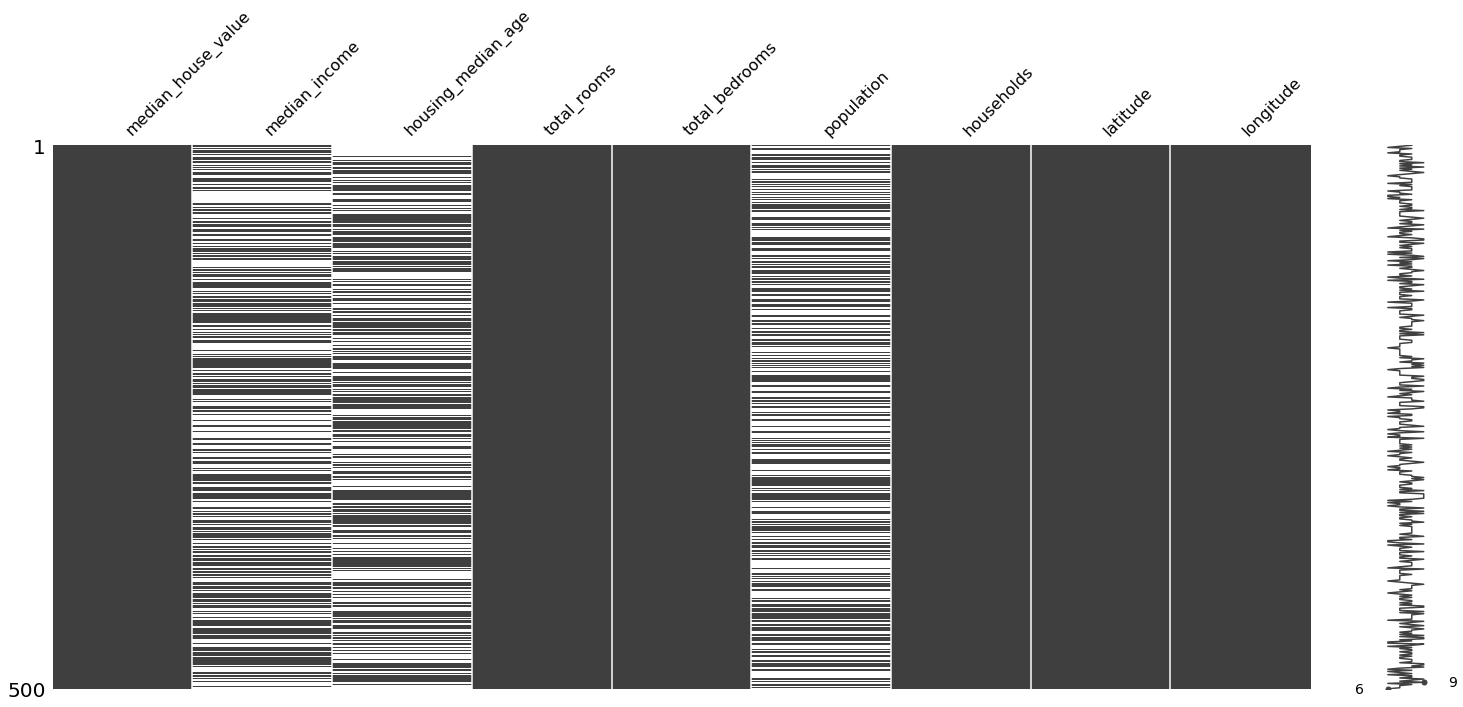

In [ ]:
%matplotlib inline
msno.matrix(dfs[0].sample(500, random_state=32))

First, we want to estimate the score on the original data:

In [47]:
original.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

In [51]:
original['median_house_value']

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [56]:
x_original = original[['median_income', 'housing_median_age', 'total_rooms', 
                       'total_bedrooms', 'population', 'households', 
                       'latitude', 'longitude']]
y_original = original['median_house_value'].values

In [ ]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(regressor, X_full, y_full,
                                  scoring='neg_mean_squared_error',
                                  cv=N_SPLITS)
    return full_scores.mean(), full_scores.std()


mses_c, stds_c  = get_full_score(X_california,y_california)
mses_d, stds_d = get_full_score(X_diabetes, y_diabetes)

mses_california[0] = mses_c
stds_california[0] = stds_c
mses_diabetes[0] = mses_d
stds_diabetes[0] = stds_d


## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

NameError: ignored